# Prepping Lakh Midi Data

The purpose of this notebook is to generate a list of valid midi files in the Lakh Midi Dataset.  These midi files will be used to construct the searchable database.  To be valid, the midi file must satisfy the following conditions:
- must contain solo piano only
- parseable by mido
- parseable by pretty_midi
- not a duplicate of a midi file in the train/test set
- has minimum number of note onset events (30)

In [1]:
%matplotlib inline

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import glob
from mido import MidiFile
import pretty_midi
import pickle

### Solo piano only, parseable by mido

In [3]:
src_dir = 'lmd_full'

In [4]:
filelist_all = []
for fname in glob.glob('{}/*/*.mid'.format(src_dir)):
    filelist_all.append(fname)

In [5]:
len(filelist_all)

178561

In [6]:
def isValidSoloPiano(infile):
    try:
        mid = MidiFile(infile)
        for i, track in enumerate(mid.tracks):
            #print("Track {}: {}".format(i, track))
            for msg in track:
                if msg.type == 'program_change' and msg.program != 0:
                    return False
        return True
    except:
        return False # cannot be read in, invalid MIDI

In [7]:
def getListSoloPiano(full_list):
    filelist_piano = []
    print('Processing ', end='')
    for i, midfile in enumerate(full_list):
        if isValidSoloPiano(midfile):
            filelist_piano.append(midfile)
        if i % 1000 == 0:
            print('.', end='')
    print(' done')
    return filelist_piano

In [7]:
#filelist_piano = getListSoloPiano(filelist_all)

Processing ................................................................................................................................................................................... done


In [8]:
len(filelist_piano)

22286

In [8]:
def dumpToFile(filelist, outfile):
    with open(outfile, 'w') as f:
        for curfile in filelist:
            f.write('{}\n'.format(curfile))

In [9]:
def loadFilelist(infile):
    lines = []
    with open(infile, 'r') as f:
        for line in f:
            lines.append(line.strip())
    return lines

In [10]:
lakh_piano_filelist = 'tmp/lakh.piano.list'

In [11]:
#dumpToFile(filelist_piano, lakh_piano_filelist)
filelist_piano = loadFilelist(lakh_piano_filelist)

### Not a duplicate of a midi file in the train/test set

In [12]:
def getTrainTestFilelist():
    r = []
    for i in range(1,101):
        midfile = 'data/midi/p{}.mid'.format(i)
        r.append(midfile)
    return  r

In [13]:
def getNoteHistogram(midfile):
    result = np.zeros(128)
    mid = MidiFile(midfile)
    for i, track in enumerate(mid.tracks):
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0 and msg.note >= 21 and msg.note <= 108:
                result[msg.note] += 1
    return result

In [14]:
def getNoteHistogram_batch(midfiles):
    R = np.zeros((len(midfiles), 128))
    for i, midfile in enumerate(midfiles):
        R[i, :] = getNoteHistogram(midfile)
    return R

In [15]:
filelist_query = getTrainTestFilelist()

In [16]:
hist_queries = getNoteHistogram_batch(filelist_query)

In [17]:
hist_filler = getNoteHistogram_batch(filelist_piano)

In [21]:
with open('tmp/hist_filler.pkl', 'wb') as f:
    pickle.dump(hist_filler, f)

In [ ]:
with open('tmp/hist_filler.pkl', 'rb') as f:
    hist_filler = pickle.load(f)

In [22]:
def calcHistDistances(hist_query_batch, hist_filler_batch):
    D = np.zeros((hist_query_batch.shape[0], hist_filler_batch.shape[0]))
    for i in range(hist_query_batch.shape[0]):
        hist_q = hist_query_batch[i, :]
        numQueryNotes = np.sum(hist_q)
        D[i,:] = np.sum(np.abs(hist_q.reshape((1,-1)) - hist_filler_batch), axis=1) / numQueryNotes
    return D

In [23]:
def visualizeDistances(D):
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.hist(D.reshape(-1), bins = np.arange(0,2,.01))
    plt.xlabel('Normalized Histogram Distance')
    plt.ylabel('Count')
    plt.subplot(1,2,2)
    plt.hist(D.reshape(-1), bins = np.arange(0,.5,.01))
    plt.xlabel('Normalized Histogram Distance')
    plt.ylabel('Count')

In [24]:
D = calcHistDistances(hist_queries, hist_filler)

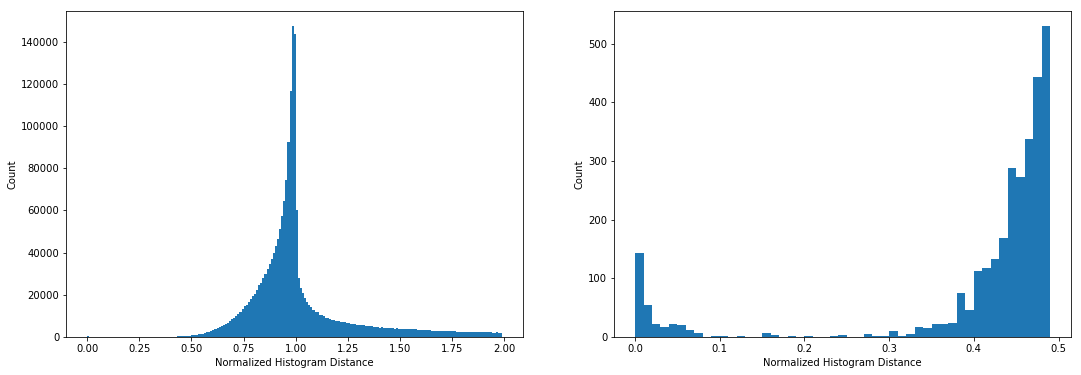

In [25]:
visualizeDistances(D)

In [26]:
def getListOfPotentialDuplicates(D, thresh):
    idxs = np.array(np.argwhere(D < thresh))[:,1]
    return idxs

In [87]:
idxs_duplicate = getListOfPotentialDuplicates(D, 0.3)

In [88]:
len(idxs_duplicate)

321

### Has minimum number of note onset events

In [89]:
def getListOfEmptyMidiFiles(H, thresh = 0):
    totalNotes = np.sum(H[:,20:109], axis=1) # valid note range is [21, 108] inclusive
    return np.nonzero(totalNotes <= thresh)[0]

In [90]:
idxs_empty = getListOfEmptyMidiFiles(hist_filler, 30)

In [94]:
len(idxs_empty)

1904

### Parseable by pretty_midi

In [108]:
def getListOfCorruptMidiFiles(filelist_piano):
    idxs = []
    for i, fullpath in enumerate(filelist_piano):
        try:
            midi_data = pretty_midi.PrettyMIDI(fullpath)
            noteTimes = midi_data.get_onsets()
        except:
            idxs.append(i)
    return idxs

In [109]:
idxs_corrupt = getListOfCorruptMidiFiles(filelist_piano)

/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [110]:
len(idxs_corrupt)

25

In [111]:
with open('tmp/corrupt.pkl', 'wb') as f:
    pickle.dump(idxs_corrupt, f)

In [118]:
with open('tmp/corrupt.pkl', 'rb') as f:
    idxs_corrupt = pickle.load(f)

### Create a pruned list of acceptable midi files

In [113]:
idxsToRemove = []
idxsToRemove.extend(idxs_duplicate)
idxsToRemove.extend(idxs_empty)
idxsToRemove.extend(idxs_corrupt)

In [114]:
filelist_piano_pruned = [x for i, x in enumerate(filelist_piano) if i not in idxsToRemove]

In [115]:
len(filelist_piano_pruned)

20042

In [116]:
with open('cfg_files/lakh.pruned.list', 'w') as f:
    for curfile in filelist_piano_pruned:
        f.write('{}\n'.format(curfile))